# Projeto Sentiment Analysis - Mosteiro dos Jerônimos #

**Importação das Bibliotecas e da Base de Dados**

In [1]:
import pandas as pd
import numpy as np
import nltk
import textblob 
from textblob.blob import WordList
import wordcloud
from pattern.en import lemma
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
mosteiro = pd.read_csv("arquivos\\mosteiro.csv", sep = ',', usecols = ['autor_comentarios', 'corpo_comentarios', 'data_comentarios', 'titulo_comentarios'])

In [5]:
mosteiro.head(30)

,autor_comentarios,corpo_comentarios,data_comentarios,titulo_comentarios
0,NaN,NaN,NaN,NaN
1,Anastasia P,It’s was ok; an empty building with a nice spo...,"Written July 9, 2022",Ok but expensive
2,Murray F,So we waited in line for the monastery to find...,"Written July 8, 2022",Scammed at ticket booth
3,kf17020,Very nice building to see and courtyard to vie...,"Written July 8, 2022",Beautiful courtyard
4,Nadina P,"Generally, I was let down by most of the touri...","Written July 7, 2022",My favorite site!
5,Therese G,"We were able to attend Sunday mass here, plent...","Written July 6, 2022",Nice place for Sunday Mass
6,RichardK938,This monastery is a must see for everyone in L...,"Written July 4, 2022",Highlight of Lisbon
7,B1714D,The Jeronimo Monastery is in the southwestern ...,"Written July 3, 2022",The peak of colonial Portugal
8,gibswong,Splendid building of sculptured stone on a gra...,"Written June 30, 2022",Splendid building of sculptured stone
9,Steviefull,Having walked along the Tagus and took in Bele...,"Written June 29, 2022",A Beautiful Building


**Tratando a data, retirando o *Written* e se notou que a cada 11 linhas havia uma linha NaN**

In [6]:
data_df = []
for i in range(1, len(mosteiro['data_comentarios'])):
    if i%11 == 0:
        continue
    else:
        data = mosteiro['data_comentarios'][i][8:]
        data_df.append(data)

In [7]:
mosteiro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8750 entries, 0 to 8749
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   autor_comentarios   7954 non-null   object
 1   corpo_comentarios   7954 non-null   object
 2   data_comentarios    7954 non-null   object
 3   titulo_comentarios  7954 non-null   object
dtypes: object(4)
memory usage: 273.6+ KB


**Tratandos os valores NaN antes citados**

In [8]:
mosteiro.dropna(inplace =  True, how = 'all')

**Tratando algumas colunas, criando algumas e dropando outras**

In [9]:
mosteiro['text'] = mosteiro['titulo_comentarios'] + ' ' + mosteiro['corpo_comentarios']

In [10]:
mosteiro.drop(['data_comentarios','corpo_comentarios','titulo_comentarios'], axis = 1, inplace = True )

In [11]:
mosteiro['data'] = data_df
mosteiro['Ano'] = pd.to_datetime(mosteiro['data']).dt.year
mosteiro['Mes'] = pd.to_datetime(mosteiro['data']).dt.month

**Nessa etapa foi realizado o pre-processamento dos dados de texto, vindo da coluna *text*. Mantendo apenas caracteres do alfabeto e os espaços, colocando-os em minúsculo, criando tokens das palavras, retirando os stopwords padrões da língua inglesa e por fim, utilizando a técnica de lematização para trabalhar com maior padronização.**

In [12]:
def pre_processing(text):
    text = "".join([c for c in text if c.isalpha() or c.isspace()])
    text = text.lower()
    text = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    text = [word for word in text if not word in stopwords]
    ' '.join(text)
    text = [lemma(word) for word in text]
    ' '.join(text)
    return text

In [14]:
mosteiro['text'] = mosteiro['text'].apply(pre_processing)

**Criando a instância do TextBlobo para gerar a análise de sentimento. De acordo com a pontuação de sentimento e subjetividade, classifica nas colunas criadas *Sentimento* e *Subjetividade* .**

In [15]:
sentiment = textblob.sentiments.PatternAnalyzer()
mosteiro[['Sentimento', 'Subjetividade']] = 0

In [16]:
i = 0
for text in mosteiro['text']:
    sent_analise = sentiment.analyze(text)
    if sent_analise[1] > 0.3:
        mosteiro['Subjetividade'].iloc[i] = 'Subjetivo'
        if sent_analise[0] < 0:
            mosteiro['Sentimento'].iloc[i] = 'Negativo'
            i+=1
        elif sent_analise[0] == 0:
            mosteiro['Sentimento'].iloc[i] = 'Neutro'
            i+=1
        else:
            mosteiro['Sentimento'].iloc[i] = 'Positivo'
            i+=1
    else:
        mosteiro['Subjetividade'].iloc[i] = 'Objetivo'
        if sent_analise[0] < 0:
            mosteiro['Sentimento'].iloc[i] = 'Negativo'
            i+=1
        elif sent_analise[0] == 0:
            mosteiro['Sentimento'].iloc[i] = 'Neutro'
            i+=1
        else:
            mosteiro['Sentimento'].iloc[i] = 'Positivo'
            i+=1

C:\Users\Diego\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


**Criação de uma função para facilitar a utilização dos bigrams e trigrams, sem ter que ficar repetindo o código**

In [17]:
def bi_tri_grams(text, n = 10):
    sentence = ' '.join(text)
    token = nltk.word_tokenize(sentence)
    bigram = list(nltk.bigrams(token))
    trigram = list(nltk.trigrams(token))
    
    freqdist_bi = nltk.FreqDist(bigram)
    freqdist_tri = nltk.FreqDist(trigram)
    
    return print('Most commons bigrams: {}\n\n\nMost commons trigrams: {}'.format(freqdist_bi.most_common(n = n),freqdist_tri.most_common(n = n)))
    
    

In [18]:
mosteiro.Sentimento.value_counts()

Positivo    7478
Negativo     241
Neutro       235
Name: Sentimento, dtype: int64

In [19]:
mosteiro.Subjetividade.value_counts()

Subjetivo    7265
Objetivo      689
Name: Subjetividade, dtype: int64

- **Analisando-se os dados, há uma quantidade expressivamente maior de comentários positivos a negativos ou neutro**
- **O nível de subjetividade é bem maior ao de objetividade, o que já era esperado se tendo a base de dados do TripAdvisor e com isso a opinião das pessoas**

In [20]:
pos_comments_ano = mosteiro.Sentimento[mosteiro.Sentimento == 'Positivo'].groupby(by = mosteiro.Ano).agg('count')
neg_comments_ano = mosteiro.Sentimento[mosteiro.Sentimento == 'Negativo'].groupby(by = mosteiro.Ano).agg('count')
pos_comments_mes = mosteiro.Sentimento[mosteiro.Sentimento == 'Positivo'].groupby(by = mosteiro.Mes).agg('count')
neg_comments_mes = mosteiro.Sentimento[mosteiro.Sentimento == 'Negativo'].groupby(by = mosteiro.Mes).agg('count')

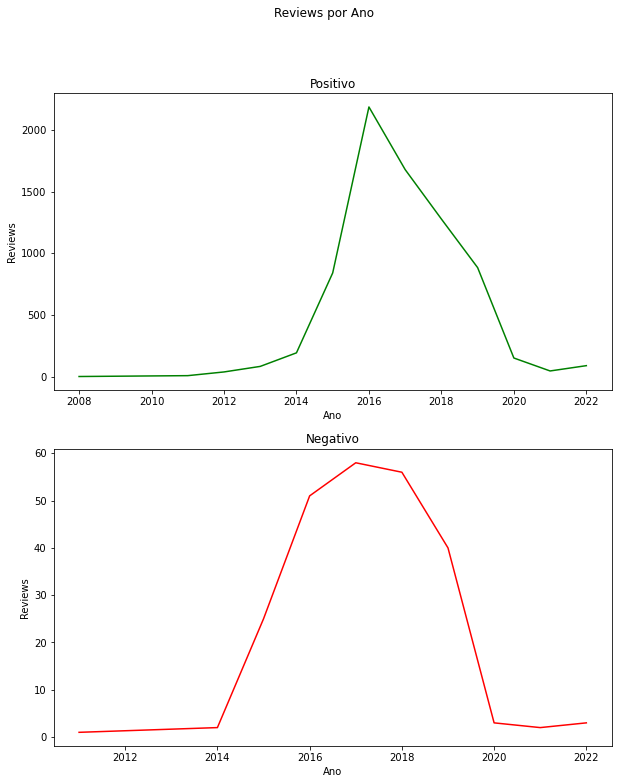

In [21]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (10,12))
sns.lineplot(x = pos_comments_ano.index, y = pos_comments_ano.values, ax = ax1, color = 'g')
sns.lineplot(x = neg_comments_ano.index, y = neg_comments_ano.values, ax = ax2, color = 'r')
ax1.set_ylabel('Reviews')
ax2.set_ylabel('Reviews')
ax1.set_title('Positivo')
ax2.set_title('Negativo')
plt.suptitle('Reviews por Ano')
plt.show()

- **É possível notar um grande aumento dentre 2014 a 2017, com queda vertiginosa a partir de 2018, voltando em 2020 a números tão baixos quanto no período antes do crescimento em 2014.**
- **Esse padrão é percebido tanto nos comentários positivos quanto negativos e teria que ser melhor investigado para saber as mudanças, seja no TripAdvisor ou no Mosteiro dos Jerônimos, nesse período**

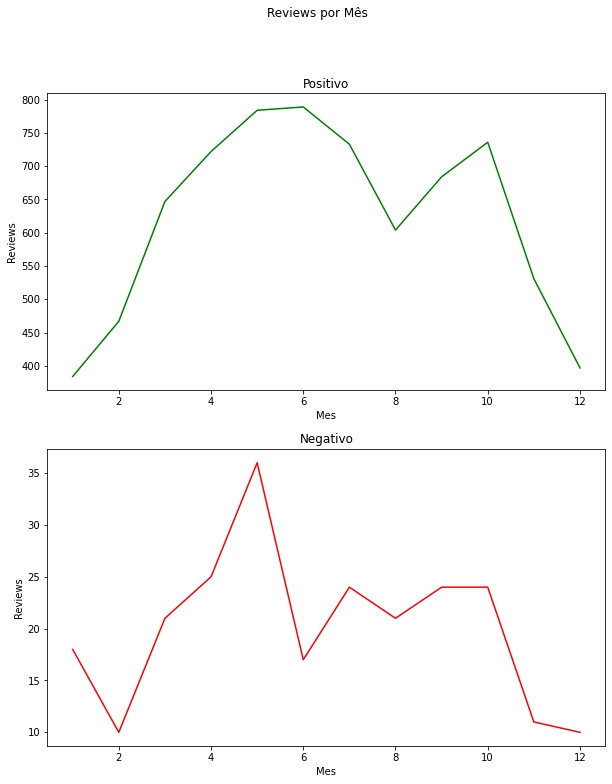

In [22]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (10,12))
sns.lineplot(x = pos_comments_mes.index, y = pos_comments_mes.values, ax = ax1, color = 'g')
sns.lineplot(x = neg_comments_mes.index, y = neg_comments_mes.values, ax = ax2, color = 'r')
ax1.set_ylabel('Reviews')
ax2.set_ylabel('Reviews')
ax1.set_title('Positivo')
ax2.set_title('Negativo')
plt.suptitle('Reviews por Mês')
plt.show()

- **Relacionando os dados aos meses do ano, pode-se inferir que, no que tange os comentários positivos, os picos se encontram d de abril a setembro e depois de setembro a novembro. Isso pode vir a ser referente, primeiro ao pico do final da primavera e do inicio do verão, maior pico de pessoas na região e depois um segundo pico com um período menos latente, que as pessoas possam usufruir com menos fila, por exemplo. São suposições e seriam necessários mais dados para comprovar ou não.**
- **Os dados dos comentários negativos tem um pico semelhante ao primeiro pico dos comentários positivos, isso pode corroborar com o fato de que período mais cheios, com mais gente, pode causar transtornos para os visitantes, gerando comentários negativos.** 
- **Um outro fato para se observar é que esses comentários podem ter sido realizados posteriormente ao período de visitação, o que pode interferir com a escala temporal**

In [23]:
neg_palavras = list()
pos_palavras = list()
total_palavras = list()
for text in mosteiro[mosteiro.Sentimento == 'Negativo'].text:
    for palavra in text:
        neg_palavras.append(palavra)

for text in mosteiro[mosteiro.Sentimento == 'Positivo'].text:
    for palavra in text:
        pos_palavras.append(palavra)
total_palavras = neg_palavras + pos_palavras

In [24]:
frequencia = nltk.FreqDist(total_palavras)
most_common_unigram = frequencia.most_common(n = 20)
most_common_unigram

[('monastery', 4744),
 ('visit', 4630),
 ('beautiful', 3782),
 ('church', 3177),
 ('see', 3001),
 ('worth', 2624),
 ('place', 2426),
 ('architecture', 2382),
 ('lisbon', 2298),
 ('go', 2283),
 ('ticket', 2151),
 ('get', 2140),
 ('build', 1877),
 ('line', 1857),
 ('belem', 1829),
 ('queue', 1660),
 ('cloister', 1621),
 ('history', 1535),
 ('inside', 1458),
 ('free', 1438)]

- **As principais palavras são: Monastery; Visit ; Beautiful ; Church ; See. Que ressalta o valor positivo agregado nos comentários.**
- **Em contrapartida, dentro das 20 principais palavras, encontra-se Ticket; Line; Queue. O que pode ser um problema, mas temos que observar mais**

In [25]:
bi_tri_grams(neg_palavras)

Most commons bigrams: [(('long', 'queue'), 27), (('buy', 'ticket'), 24), (('long', 'line'), 22), (('worth', 'visit'), 13), (('must', 'see'), 12), (('mosteiro', 'do'), 11), (('next', 'door'), 10), (('ticket', 'office'), 10), (('line', 'get'), 10), (('belem', 'tower'), 10)]


Most commons trigrams: [(('mosteiro', 'do', 'jeronimo'), 8), (('museum', 'next', 'door'), 7), (('well', 'worth', 'visit'), 6), (('long', 'line', 'get'), 5), (('vasco', 'da', 'gama'), 5), (('line', 'buy', 'ticket'), 4), (('world', 'heritage', 'site'), 4), (('vasco', 'de', 'gama'), 4), (('archeological', 'museum', 'next'), 3), (('line', 'get', 'church'), 3)]


In [26]:
bi_tri_grams(pos_palavras)

Most commons bigrams: [(('worth', 'visit'), 1053), (('must', 'see'), 715), (('well', 'worth'), 660), (('buy', 'ticket'), 533), (('da', 'gama'), 490), (('vasco', 'da'), 479), (('church', 'free'), 440), (('visit', 'lisbon'), 341), (('beautiful', 'monastery'), 327), (('place', 'visit'), 322)]


Most commons trigrams: [(('vasco', 'da', 'gama'), 461), (('well', 'worth', 'visit'), 367), (('vasco', 'de', 'gama'), 240), (('must', 'see', 'lisbon'), 159), (('tomb', 'vasco', 'da'), 155), (('world', 'heritage', 'site'), 128), (('torre', 'de', 'belem'), 123), (('definitely', 'worth', 'visit'), 121), (('unesco', 'world', 'heritage'), 106), (('pastei', 'de', 'belem'), 106)]


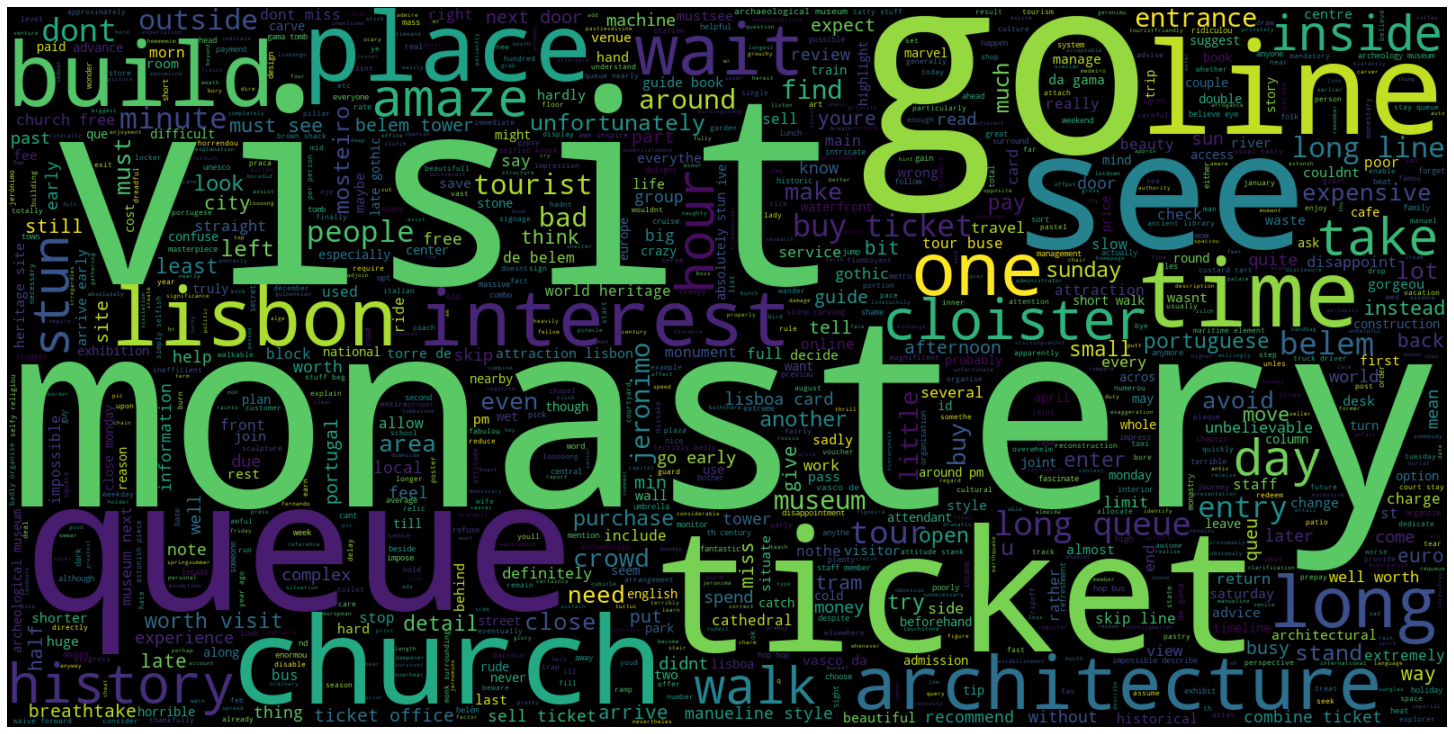

In [27]:
wc = wordcloud.WordCloud(max_words = 1000, width = 1600, height = 800,
                         stopwords = wordcloud.STOPWORDS, background_color='black').generate(" ".join(neg_palavras))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wc, interpolation='bilinear')
plt.show()

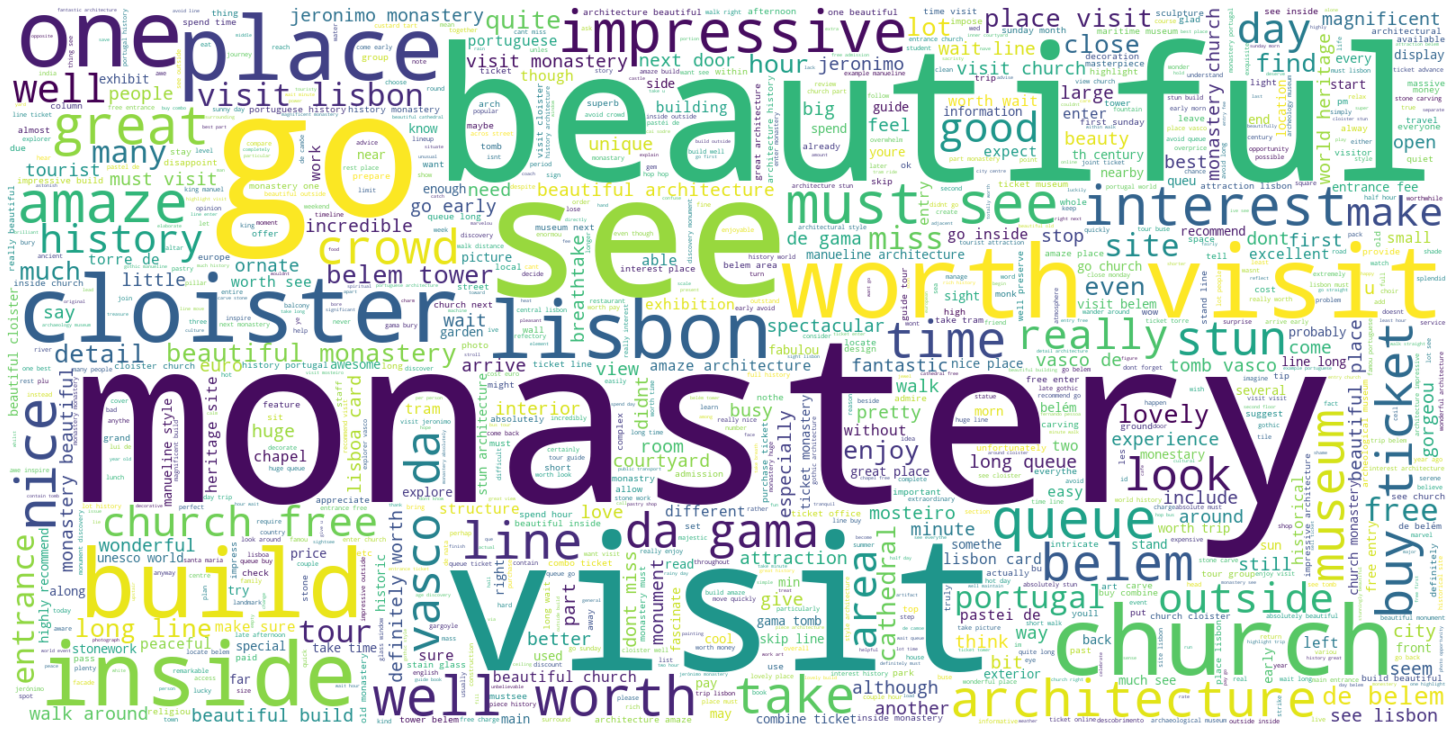

In [28]:
wc = wordcloud.WordCloud(max_words = 1000, width = 1600, height = 800,
                         stopwords = wordcloud.STOPWORDS, background_color='white').generate(" ".join(pos_palavras))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wc, interpolation='bilinear')
plt.show()

**Após a Análise dos Bigrams e Trigams e a geração dos WordClouds, pode-se chegar a algumas conclusões e possíveis estudos futuros para melhoriais.**

- **Interessante destacar que dos comentários positivos, é demonstrado interesse pela arquitetura do local, pela beleza dele e pelos pontos turísticos nas redondezas, como a Torre de Belém e o Pastel de Belém.**
- **Com relação aos comentários negativos, destacam-se as longas filas e o guichê de compra de ingressos.**

**Com a análise, pode se inferir problemas quanto ao gerencimento da venda de tickets e a capacidade de pessoas, criando filas que incomodam os clientes que buscam visitar o local e que se encantam com o mesmo. Como possíveis medidas, seria interessante avaliar o sistema de venda de tickets, o tempo atual de espera (nos cenários de baixa e alta temporada) e buscar alternativas de implementação para redução do tempo de espera, como um FastPass (similiar ao existente na Disney) comprado a priori para agilizar o processo e melhorar a experiência**